# Spaceship Titanic Kaggle Competition, by [Andres Perez](https://www.andresperez.info/)
[README](./README.md)

In [287]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [288]:
%pip install lightgbm catboost

In [381]:
import time

# Data wrangling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

## Read in the Data

In [290]:
# Google Colab
train = pd.read_csv('/content/drive/MyDrive/kaggle/spaceship-titanic/data/train.csv')
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [291]:
train.shape

(8693, 14)

In [292]:
# # Local
# train = pd.read_csv('./data/train.csv')
# train.head()

In [293]:
# Colab
test = pd.read_csv('/content/drive/MyDrive/kaggle/spaceship-titanic/data/test.csv')
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [294]:
test.shape

(4277, 13)

In [295]:
# # Local
# test = pd.read_csv('./data/test.csv')
# test.head()

## EDA
Using this notebook as a guide: [Geunho](https://www.kaggle.com/code/arootda/pycaret-visualization-optimization-0-81/notebook)

### Combine Train and Test data for EDA

In [296]:
data = pd.concat([train, test]).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12970 entries, 0 to 12969
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   12970 non-null  object 
 1   HomePlanet    12682 non-null  object 
 2   CryoSleep     12660 non-null  object 
 3   Cabin         12671 non-null  object 
 4   Destination   12696 non-null  object 
 5   Age           12700 non-null  float64
 6   VIP           12674 non-null  object 
 7   RoomService   12707 non-null  float64
 8   FoodCourt     12681 non-null  float64
 9   ShoppingMall  12664 non-null  float64
 10  Spa           12686 non-null  float64
 11  VRDeck        12702 non-null  float64
 12  Name          12676 non-null  object 
 13  Transported   8693 non-null   object 
dtypes: float64(6), object(8)
memory usage: 1.4+ MB


### Missing values

In [297]:
# Percentages of missing data
(data.isna().sum() / len(data)) * 100

PassengerId      0.000000
HomePlanet       2.220509
CryoSleep        2.390131
Cabin            2.305320
Destination      2.112567
Age              2.081727
VIP              2.282190
RoomService      2.027756
FoodCourt        2.228219
ShoppingMall     2.359291
Spa              2.189668
VRDeck           2.066307
Name             2.266769
Transported     32.976099
dtype: float64

Small amount of missing values, but filling them is better than dropping. Numericals will probably be filled with means, categoricals with modes. I have read in other notebooks that missing values in the spending categories can be correlated with CryoSleep category.

### Identify feature types

- Categorical: PassengerId, HomePlanet, CryoSleep, Cabin, Destination, VIP, Name
- Numerical: Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
- Target: Transported

In [298]:
data.columns

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name', 'Transported'],
      dtype='object')

In [299]:
# Build lists of features by type for easy panda df usage. Borrowed idea from Geunho
categoricals = [
    "PassengerId",
    "HomePlanet",
    "CryoSleep",
    "Cabin",
    "Destination",
    "VIP",
    "Name",
]

numericals = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

target = "Transported"


In [300]:
# Descriptive Statistics for numerical features
data[numericals].describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,12700.000000,12707.000000,12681.000000,12664.000000,12686.000000,12702.000000
mean,28.771969,222.897852,451.961675,174.906033,308.476904,306.789482
std,14.387261,647.596664,1584.370747,590.558690,1130.279641,1180.097223
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,49.000000,77.000000,29.000000,57.000000,42.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


### Explore Feature Distributions

#### Target Variable: Transported

Our target is categorical True/False. Check distribution to make sure it's balanced

''

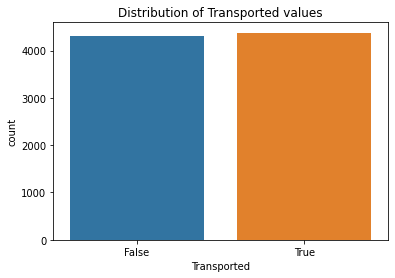

In [301]:
# Plot target distribution to verify balanced data
sns.countplot(data=data["Transported"], x=data["Transported"])
plt.title('Distribution of Transported values')
;

#### Categorical Features

##### PassengerId

Passenger groups are hidden in the first four characters of this feature. Will use to create a IsFamily feature.

In [302]:
# Create Group, Id and Last Name features
tmp = data.copy()
tmp['Group'] = tmp['PassengerId'].apply(lambda x: str(x)[0:4])
tmp['Id'] = tmp['PassengerId'].apply(lambda x: int(str(x)[5:]))
tmp['LastName'] = tmp['Name'].apply(lambda x: str(x).split()[1] if len(str(x).split()) > 1 else str(x).split()[0])
tmp.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,LastName
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,1,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,1,Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,2,Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1,Santantines


In [303]:
tmp["IsFamily"] = tmp["Group"].map(
    tmp.groupby(by=["Group"]).count()["PassengerId"] > 1
).map({True: 1, False: 0})


In [304]:
tmp.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group,Id,LastName,IsFamily
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,1,Ofracculy,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,1,Vines,0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,1,Susent,1
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,2,Susent,1
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,1,Santantines,0


In [305]:
tmp['IsFamily'].value_counts()

0    7145
1    5825
Name: IsFamily, dtype: int64

''

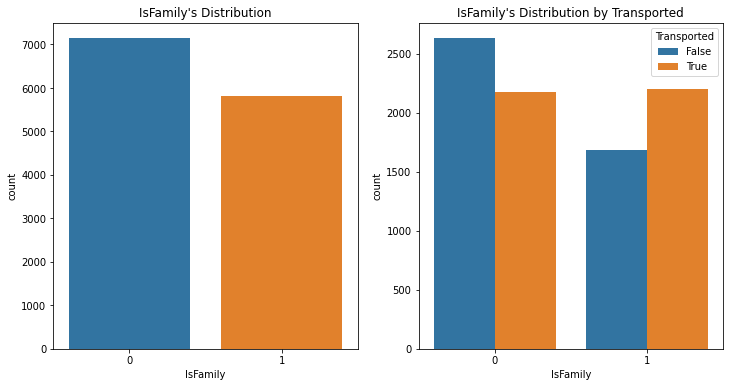

In [306]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'IsFamily'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=tmp,
    x=tmp[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=tmp,
    x=tmp[feature],
    hue='Transported',
)
;

##### HomePlanet

''

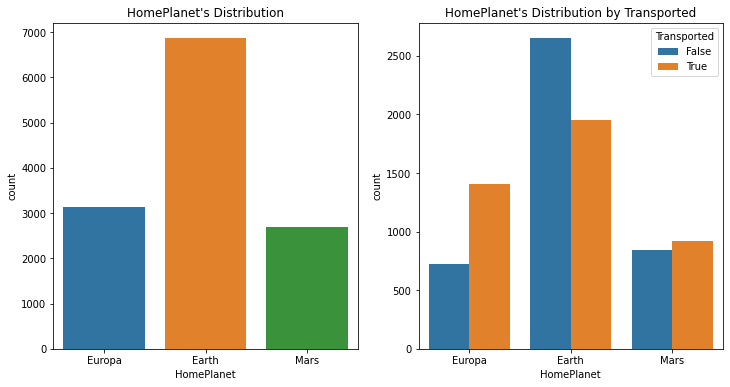

In [307]:
# Plot HomePlanet distribution and distribution by target. With help from Geunho's functions
feature = 'HomePlanet'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=data,
    x=data[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=data,
    x=data[feature],
    hue='Transported',
)
;

##### CryoSleep

''

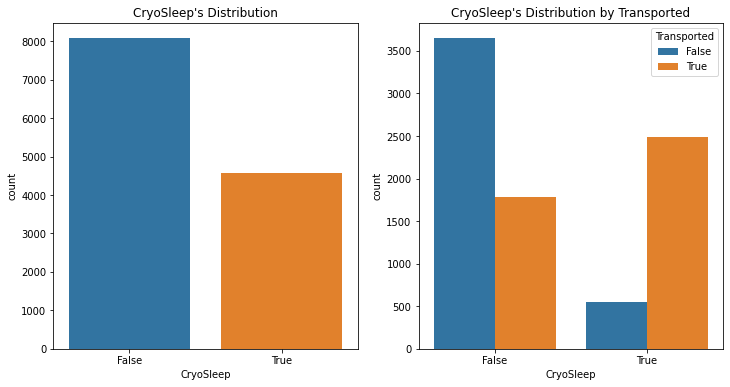

In [308]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'CryoSleep'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=data,
    x=data[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=data,
    x=data[feature],
    hue='Transported',
)
;

##### Cabin

Too many cabins for this plot to be useful. Will separate cabin feature by deck/number/side.

In [309]:
# Create Deck, Number and Side features from Cabin. Use temporary copy of data
tmp = data.copy()
tmp['Deck'] = tmp['Cabin'].apply(lambda x: str(x)[0])
tmp['Number'] = tmp['Cabin'].apply(lambda x: str(x)[2])
tmp['Side'] = tmp['Cabin'].apply(lambda x: str(x)[-1])
tmp.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Number,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,F,1,S


''

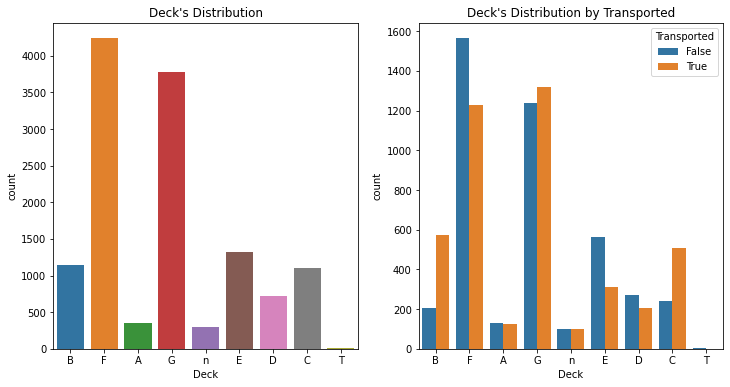

In [310]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'Deck'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=tmp,
    x=tmp[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=tmp,
    x=tmp[feature],
    hue='Transported',
)
;

''

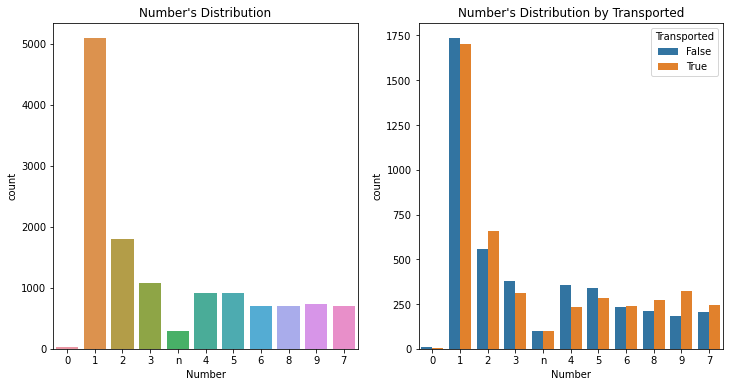

In [311]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'Number'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=tmp,
    x=tmp[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=tmp,
    x=tmp[feature],
    hue='Transported',
)
;

''

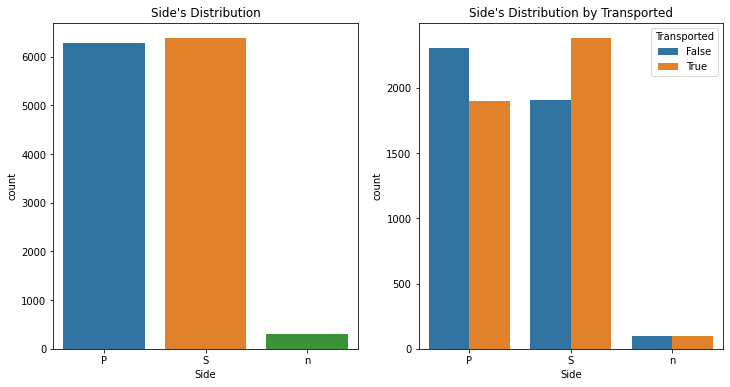

In [312]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'Side'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=tmp,
    x=tmp[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=tmp,
    x=tmp[feature],
    hue='Transported',
)
;

##### Destination

''

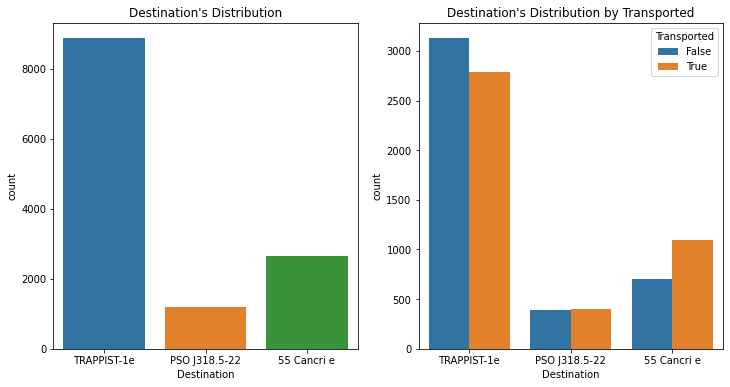

In [313]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'Destination'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=data,
    x=data[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=data,
    x=data[feature],
    hue='Transported',
)
;

##### VIP

''

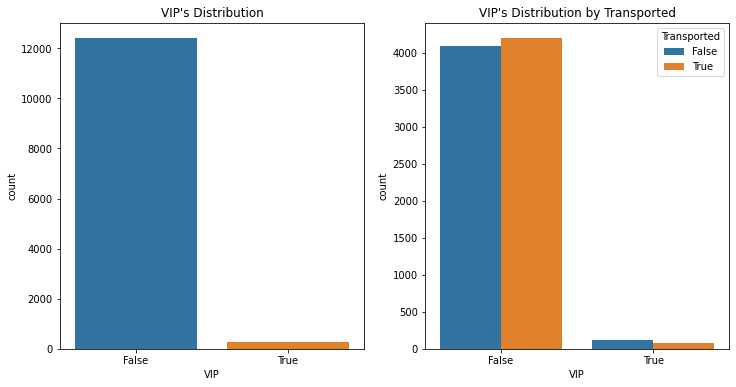

In [314]:
# Plot distribution and distribution by target. With help from Geunho's functions
feature = 'VIP'
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"{feature}'s Distribution")
sns.countplot(
    data=data,
    x=data[feature],
)
plt.subplot(1, 2, 2)
plt.title(f"{feature}'s Distribution by Transported")
sns.countplot(
    data=data,
    x=data[feature],
    hue='Transported',
)
;

#### Numerical Features

In [315]:
numericals

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

##### Age

''

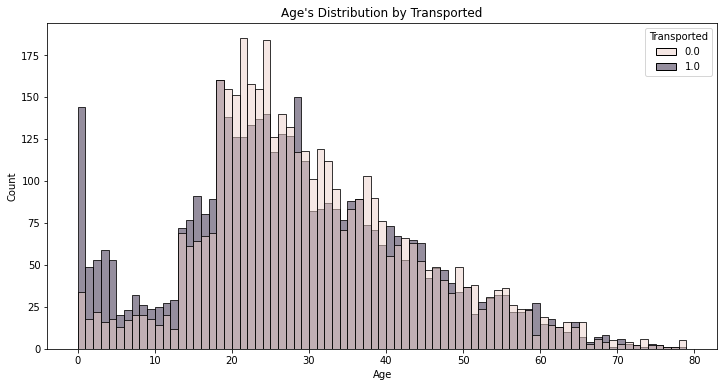

In [316]:
# Plot distribution by target. With help from Geunho's functions
feature = 'Age'
plt.figure(figsize=(12, 6))
plt.title(f"{feature}'s Distribution by Transported")
sns.histplot(
    data=data,
    x=data[feature],
    hue=data['Transported'],
    binwidth=1,
)
;
# plt.savefig(f"./figures/{feature}-distro-by-transported.png")

It appears that up to age 18 there are consistently more Transported individuals than not. Should come back and test this quantitatively.

>Create Underage feature

##### Total Spending

Group spending features into total spending

In [317]:
tmp = data.copy()
tmp['TotalSpend'] = tmp['RoomService'] + tmp['FoodCourt'] + tmp['ShoppingMall'] + tmp['Spa'] + tmp['VRDeck']

''

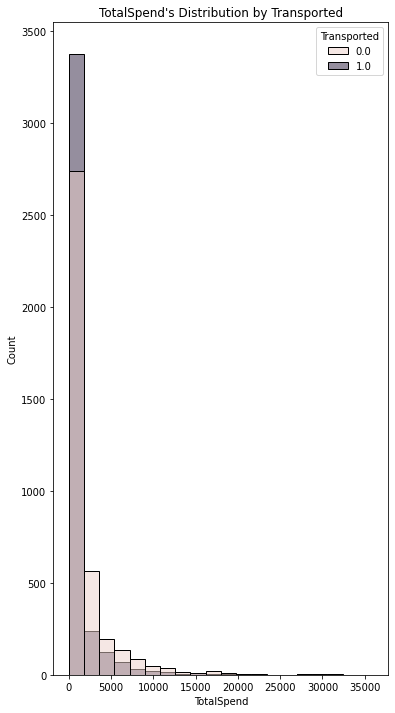

In [318]:
# Plot distribution by target. With help from Geunho's functions
feature = 'TotalSpend'
plt.figure(figsize=(6, 12))
plt.title(f"{feature}'s Distribution by Transported")
sns.histplot(
    data=tmp,
    x=tmp[feature],
    hue=tmp['Transported'],
    bins=20,
)
;

> Create Spent/DidNotSpend feature

## Imputing Missing Values

In order to maximize the amount of data I will input into models, I will impute missing values.

In [319]:
# Reminder of missing values
(data.isna().sum() / len(data)) * 100


PassengerId      0.000000
HomePlanet       2.220509
CryoSleep        2.390131
Cabin            2.305320
Destination      2.112567
Age              2.081727
VIP              2.282190
RoomService      2.027756
FoodCourt        2.228219
ShoppingMall     2.359291
Spa              2.189668
VRDeck           2.066307
Name             2.266769
Transported     32.976099
dtype: float64

### Categorical Features

Let's view unique values for the categorical features, this should reveal the first imputable values.

In [320]:
# Show unique values for each categorical feature
for col in categoricals:
    print(col, data[col].unique())


PassengerId ['0001_01' '0002_01' '0003_01' ... '9271_01' '9273_01' '9277_01']
HomePlanet ['Europa' 'Earth' 'Mars' nan]
CryoSleep [False True nan]
Cabin ['B/0/P' 'F/0/S' 'A/0/S' ... 'D/296/P' 'D/297/P' 'G/1498/S']
Destination ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
VIP [False True nan]
Name ['Maham Ofracculy' 'Juanna Vines' 'Altark Susent' ... 'Jayrin Pore'
 'Kitakan Conale' 'Lilace Leonzaley']


#### Impute values:
- HomePlanet -> mode
- CryoSleep -> mode
- Cabin -> None. Will be dropped
- Destination -> mode
- VIP -> mode
- Name -> None. Will be dropped

In [321]:
# Fill NaNs in categorical features with the mode
data["HomePlanet"].fillna(data["HomePlanet"].mode()[0], inplace=True)
data["CryoSleep"].fillna(data["CryoSleep"].mode()[0], inplace=True)
data["Destination"].fillna(data["Destination"].mode()[0], inplace=True)
data["VIP"].fillna(data["VIP"].mode()[0], inplace=True)


In [322]:
# Sanity check
(data.isna().sum() / len(data)) * 100

PassengerId      0.000000
HomePlanet       0.000000
CryoSleep        0.000000
Cabin            2.305320
Destination      0.000000
Age              2.081727
VIP              0.000000
RoomService      2.027756
FoodCourt        2.228219
ShoppingMall     2.359291
Spa              2.189668
VRDeck           2.066307
Name             2.266769
Transported     32.976099
dtype: float64

### Numerical Features

In [323]:
for col in numericals:
    print(col, data[col].unique())

Age [39. 24. 58. 33. 16. 44. 26. 28. 35. 14. 34. 45. 32. 48. 31. 27.  0.  1.
 49. 29. 10.  7. 21. 62. 15. 43. 47.  2. 20. 23. 30. 17. 55.  4. 19. 56.
 nan 25. 38. 36. 22. 18. 42. 37. 13.  8. 40.  3. 54.  9.  6. 64. 67. 61.
 50. 41. 57. 11. 52. 51. 46. 60. 63. 59.  5. 79. 68. 74. 12. 53. 65. 71.
 75. 70. 76. 78. 73. 66. 69. 72. 77.]
RoomService [   0.  109.   43. ... 1278. 2835.  652.]
FoodCourt [   0.    9. 3576. ...  873. 4813.  601.]
ShoppingMall [   0.   25.  371. ... 2156. 1258. 3851.]
Spa [   0.  549. 6715. ... 1872. 1716. 1812.]
VRDeck [    0.    44.    49. ...  3093. 14834.   494.]


In [324]:
for col in numericals:
    if col == "Age":
        data[col].fillna(data[col].mean(), inplace=True)
    else:
        data[col].fillna(0, inplace=True)


In [325]:
# Sanity check
(data.isna().sum() / len(data)) * 100

PassengerId      0.000000
HomePlanet       0.000000
CryoSleep        0.000000
Cabin            2.305320
Destination      0.000000
Age              0.000000
VIP              0.000000
RoomService      0.000000
FoodCourt        0.000000
ShoppingMall     0.000000
Spa              0.000000
VRDeck           0.000000
Name             2.266769
Transported     32.976099
dtype: float64

> More imputing will be performed after feature engineering

## Feature Engineering

From EDA we have found the following useful features that can be engineered from original features:
- IsFamily: Based on PassengerId if there are 2 or more people in a group, we will consider that a 'Family'. From distriution these seem to be more likely to be Transported
- Deck, Number and Side: From Cabin feature we have found these derivated features to be useful.
- Age bins: From EDA it appears that creating age categories results in different likelihoods of being Transported
- Spent/DidNotSpend: Creating a Total Spending feature and then splitting into Spent/DidNotSpend categories should also be useful

### IsFamily

In [326]:
# Same code as EDA but on actual 'data' df
data['Group'] = data['PassengerId'].apply(lambda x: str(x)[0:4])
data['Id'] = data['PassengerId'].apply(lambda x: int(str(x)[5:]))
data["IsFamily"] = data["Group"].map(
    data.groupby(by=["Group"]).count()["PassengerId"] > 1
).map({True: 1, False: 0})
data['IsFamily'].value_counts()

0    7145
1    5825
Name: IsFamily, dtype: int64

### Deck, Number, Side

In [327]:
# Also reusing code from EDA
data['Deck'] = data['Cabin'].apply(lambda x: str(x)[0])
data['Number'] = data['Cabin'].apply(lambda x: str(x)[2])
data['Side'] = data['Cabin'].apply(lambda x: str(x)[-1])
data['Deck'].value_counts(), data['Number'].value_counts(), data['Side'].value_counts()

(F    4239
 G    3781
 E    1323
 B    1141
 C    1102
 D     720
 A     354
 n     299
 T      11
 Name: Deck, dtype: int64, 1    5094
 2    1808
 3    1073
 4     922
 5     915
 9     728
 6     704
 7     704
 8     698
 n     299
 0      25
 Name: Number, dtype: int64, S    6381
 P    6290
 n     299
 Name: Side, dtype: int64)

In [328]:
data['Number'].replace('n', data['Number'].mode()[0], inplace=True)
data["Number"] = data['Number'].astype(int)

### Age Bins

In [329]:
# With help from Geunho
data['AgeBin'] = 7
for i in range(6):
    data.loc[(data['Age'] >= 10*i) & (data['Age'] < 10*(i + 1)), 'AgeBin'] = i

data['AgeBin'].value_counts()

2    4460
3    2538
1    2235
4    1570
0     980
5     809
7     378
Name: AgeBin, dtype: int64

### Spent

In [330]:
# Create Total Spending as in EDA
data['TotalSpend'] = data['RoomService'] + data['FoodCourt'] + data['ShoppingMall'] + data['Spa'] + data['VRDeck']
data["Spent"] = data['TotalSpend'].apply(lambda x: 1 if x > 0 else 0)
data["Spent"].value_counts()

1    7513
0    5457
Name: Spent, dtype: int64

## Drop Unused Features and Impute new NaNs

In [331]:
# Drop Unused features
data.drop(['PassengerId', 'Name', 'Cabin'], axis=1, inplace=True)

In [332]:
# Reminder of missing values
(data.isna().sum() / len(data)) * 100


HomePlanet       0.000000
CryoSleep        0.000000
Destination      0.000000
Age              0.000000
VIP              0.000000
RoomService      0.000000
FoodCourt        0.000000
ShoppingMall     0.000000
Spa              0.000000
VRDeck           0.000000
Transported     32.976099
Group            0.000000
Id               0.000000
IsFamily         0.000000
Deck             0.000000
Number           0.000000
Side             0.000000
AgeBin           0.000000
TotalSpend       0.000000
Spent            0.000000
dtype: float64

No NaNs in engineered features, appears they have been encoded as 'n' for Deck, Cabin, and Side. Will keep this way for now.

## Encoding Categorical Features

In [333]:
# With help from Genhuo. Haven't used LabelEncoder before, curious about how it's different from Column Transformer
for col in data.columns[data.dtypes == object]:
    if col != 'Transported':
        le = LabelEncoder()
        data[col] = le.fit_transform(data[col])
        
data['CryoSleep'] = data['CryoSleep'].astype('int')
data['VIP'] = data['VIP'].astype('int')

In [334]:
data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,Id,IsFamily,Deck,Number,Side,AgeBin,TotalSpend,Spent
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,False,0,1,0,1,0,0,3,0.0,0
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,True,1,1,0,5,0,1,2,736.0,1
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False,2,1,1,0,0,1,5,10383.0,1
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False,2,2,1,0,0,1,3,5176.0,1
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,True,3,1,0,5,1,1,1,1091.0,1


## Scaling Numerical Features

In [335]:
for col in data.columns[data.dtypes == float]:
    if col != 'Transported':
        ss = StandardScaler()
        data[col] = ss.fit_transform(data[[col]])

In [336]:
data.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,Id,IsFamily,Deck,Number,Side,AgeBin,TotalSpend,Spent
0,1,0,2,0.718454,0,-0.340290,-0.281822,-0.292365,-0.269707,-0.257100,False,0,1,0,1,0,0,3,-0.510541,0
1,0,0,2,-0.335201,0,-0.170439,-0.276082,-0.249566,0.221040,-0.219449,True,1,1,0,5,0,1,2,-0.248363,1
2,1,0,2,2.053084,1,-0.273285,1.998823,-0.292365,5.732776,-0.215170,False,2,1,1,0,0,1,5,3.188082,1
3,1,0,2,0.296992,0,-0.340290,0.536429,0.342766,2.706059,-0.091947,False,2,2,1,0,0,1,3,1.333249,1
4,0,0,2,-0.897150,0,0.131863,-0.237179,-0.033861,0.235342,-0.255389,True,3,1,0,5,1,1,1,-0.121906,1


## Train, Test Split. X, y

Split data back to it's original train and test sets. Create X and y from train set and the split those into train and validation sets.

In [337]:
# Split data into original train and test sets again, but including all feature engineering and cleaning
train_re, X_test = data.iloc[:train.shape[0]], data.iloc[train.shape[0]:].drop(['Transported'], axis=1)
X, y = train_re.drop(['Transported'], axis=1), train_re['Transported'].astype(int)

In [339]:
# Train, Validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1331)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(6519, 19) (2174, 19) (6519,) (2174,)


In [340]:
X_test.shape

(4277, 19)

## Modeling

I've used [Samuel Cortinha's](https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide#Model-selection) notebook for guidance here.

### Baseline

In [341]:
y.value_counts(normalize=True)[1]

0.5036236051995858

### Training and scoring function
Create a training and scoring function to streamline model selection

In [342]:
def model_train_score(model, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val):
    
    model.fit(X_train, y_train)

    return model.score(X_train, y_train), model.score(X_val, y_val)

### Logistic Regression

In [343]:
model_train_score(LogisticRegression(max_iter=10_000))

(0.7867771130541494, 0.7842686292548298)

Substantial increase above baseline accuracy and slightly overfit.

### CatBoost
I have reviewed several submissions to this competition and most use CatBoost in their submissions.

I haven't used CatBoost before so this is a learning opportunity!

In [344]:
# Train and score CatBoost model without any tuning
model_train_score(CatBoostClassifier(random_state=1331, verbose=False))

(0.8956895229329652, 0.8017479300827967)

In [345]:
catboost = CatBoostClassifier(random_state=1331, verbose=False)

catboost.fit(X_train, y_train)

Large improvement vs. LogReg. Very overfit, let's try some GridSearching to tune this model.

#### Grid Search

In [346]:
# # Define CatBoost param grid starting with Samuel's params
# params = {
#     "n_estimators": [50, 100, 150, 200],
#     "max_depth": [4, 8, 12],
#     "learning_rate": [0.05, 0.1, 0.15],
# }

# cb_gs = GridSearchCV(
#     CatBoostClassifier(random_seed=1331, verbose=False), params, n_jobs=-1, cv=None
# )

# cb_gs.fit(X_train, y_train)

# cb_gs.score(X_train, y_train), cb_gs.score(X_val, y_val)


In [347]:
# cb_gs.best_params_

In [348]:
# # New paramgrid after first grid search
# params = {
#     "n_estimators": [200, 250, 300],
#     "max_depth": [4, 8],
#     "learning_rate": [0.1, 0.15],
# }

# cb_gs = GridSearchCV(
#     CatBoostClassifier(random_seed=1331, verbose=False), params, n_jobs=-1, cv=None
# )

# cb_gs.fit(X_train, y_train)

# cb_gs.score(X_train, y_train), cb_gs.score(X_val, y_val), cb_gs.best_params_


### Neural Network

Using [Chollet](https://www.manning.com/books/deep-learning-with-python-second-edition) for guidance.

In [404]:
model = Sequential()
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(.003)))
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(.003)))
model.add(Dense(1, activation='sigmoid'))

In [405]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

In [406]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    #batch_size=512,
    validation_data=(X_val, y_val),
    callbacks=EarlyStopping(monitor='val_loss', patience=7),
    verbose=1
)

Epoch 1/100
204/204 [==============================] - 2s 8ms/step - loss: 64.1114 - binary_accuracy: 0.4975 - val_loss: 34.8319 - val_binary_accuracy: 0.4802
Epoch 2/100
204/204 [==============================] - 1s 6ms/step - loss: 12.9598 - binary_accuracy: 0.5113 - val_loss: 3.5551 - val_binary_accuracy: 0.4885
Epoch 3/100
204/204 [==============================] - 1s 6ms/step - loss: 7.5621 - binary_accuracy: 0.5156 - val_loss: 2.4091 - val_binary_accuracy: 0.4995
Epoch 4/100
204/204 [==============================] - 1s 7ms/step - loss: 2.8427 - binary_accuracy: 0.5456 - val_loss: 1.4412 - val_binary_accuracy: 0.7507
Epoch 5/100
204/204 [==============================] - 1s 7ms/step - loss: 2.6468 - binary_accuracy: 0.5462 - val_loss: 1.9839 - val_binary_accuracy: 0.5658
Epoch 6/100
204/204 [==============================] - 1s 7ms/step - loss: 1.8743 - binary_accuracy: 0.5745 - val_loss: 1.3932 - val_binary_accuracy: 0.6973
Epoch 7/100
204/204 [==============================] - 

''

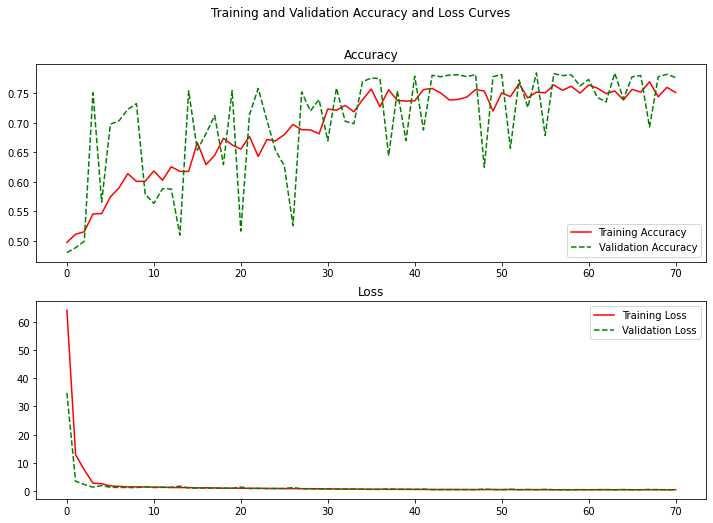

In [407]:
# Plot accuracy and loss curves
train_accuracy = history.history['binary_accuracy']
val_accuracy = history.history['val_binary_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

fig.suptitle("Training and Validation Accuracy and Loss Curves")
ax1.plot(train_accuracy, label='Training Accuracy', color='red')
ax1.plot(val_accuracy, label='Validation Accuracy', color='green', linestyle='dashed',)
ax1.set_title('Accuracy')
ax1.legend()
ax2.plot(train_loss, label='Training Loss', color='red')
ax2.plot(val_loss, label='Validation Loss', color='green', linestyle='dashed',)
ax2.set_title("Loss")
ax2.legend()
;

## Submission

In [273]:
# # Local
# # Get sample submission as df
# sample_submission = pd.read_csv("./data/sample_submission.csv")
# sample_submission


In [274]:
# Colab
# Get sample submission as df
sample_submission = pd.read_csv("/content/drive/MyDrive/kaggle/spaceship-titanic/data/sample_submission.csv")
sample_submission


,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


In [275]:
# Make predictions from CatBoost model
preds = catboost.predict(X_test)
preds


array([1, 0, 1, ..., 1, 1, 1])

In [276]:
# Create submission df from sample and map preds to True/False
submission = pd.DataFrame(
    {"PassengerId": sample_submission["PassengerId"], "Transported": preds}
)
submission["Transported"] = submission["Transported"].map({0: False, 1: True})
submission


,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [277]:
# # Local
# # Save submission with timestamp
# timestr = time.strftime("%Y%m%d-%H%M%S")
# submission.to_csv(f"./data/submission-{timestr}.csv", index=False)


In [278]:
# Colab
# Save submission with timestamp
timestr = time.strftime("%Y%m%d-%H%M%S")
submission.to_csv(f"/content/drive/MyDrive/kaggle/spaceship-titanic/data/submission-{timestr}.csv", index=False)
